In [ ]:
import zipfile
zip_ref=zipfile.ZipFile('/content/pokemon_datset.zip','r')
zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
import tensorflow as tf


directory = '/content/pokemon'


train_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='categorical',  # Use 'categorical' for multi-class classification
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.25,  # 80% of the data will be used for training
    subset='training',
    seed=123  # Provide a seed argument to ensure no overlap between training and validation
)

# Set up your image dataset for validation/testing
validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='categorical',  # Use 'categorical' for multi-class classification
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.25,  # 20% of the data will be used for validation/testing
    subset='validation',
    seed=123  # Provide the same seed to ensure no overlap between training and validation
)






Found 64 files belonging to 4 classes.
Using 48 files for training.
Found 64 files belonging to 4 classes.
Using 16 files for validation.


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# Define a function for Random Erasing augmentation
def random_erasing(img):
    p = 0.5  # Probability of applying random erasing
    s_l = 0.02  # Minimum area proportion of erasing region
    s_h = 0.4  # Maximum area proportion of erasing region
    r_1 = 0.3  # Minimum aspect ratio of erasing region
    mean = np.mean(img)

    if np.random.rand() < p:
        img_h, img_w, _ = img.shape
        img_area = img_h * img_w

        while True:
            s = np.random.uniform(s_l, s_h) * img_area
            r = np.random.uniform(r_1, 1/r_1)

            w = int(np.sqrt(s * r))
            h = int(np.sqrt(s / r))

            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        img[top:top + h, left:left + w, :] = mean

    return img

# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=random_erasing  # Apply custom random erasing function
)

# Set up your image dataset for training
train_ds = train_datagen.flow_from_directory(
    directory,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    seed=123
)

# Set up your image dataset for validation/testing
validation_ds = train_datagen.flow_from_directory(
    directory,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    seed=123
)

# Load pre-trained MobileNetV2 model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Fine-tuning: Unfreeze some layers
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Add custom classification layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)

# Combine base model with custom layers
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

# Train the model
history = model.fit(
    train_ds,
    epochs=30,
    validation_data=validation_ds,
    callbacks=[early_stopping, reduce_lr]
)


Found 64 images belonging to 4 classes.
Found 0 images belonging to 4 classes.


Epoch 1/30
2/2 [==============================] - ETA: 0s - loss: 1.4261 - accuracy: 0.4219

2/2 [==============================] - 9s 83ms/step - loss: 1.4261 - accuracy: 0.4219 - lr: 0.0010
Epoch 2/30
2/2 [==============================] - ETA: 0s - loss: 0.6528 - accuracy: 0.7812

2/2 [==============================] - 1s 499ms/step - loss: 0.6528 - accuracy: 0.7812 - lr: 0.0010
Epoch 3/30
2/2 [==============================] - ETA: 0s - loss: 0.2758 - accuracy: 0.9375

2/2 [==============================] - 1s 526ms/step - loss: 0.2758 - accuracy: 0.9375 - lr: 0.0010
Epoch 4/30
2/2 [==============================] - ETA: 0s - loss: 0.1532 - accuracy: 0.9375

2/2 [==============================] - 1s 518ms/step - loss: 0.1532 - accuracy: 0.9375 - lr: 0.0010
Epoch 5/30
2/2 [==============================] - ETA: 0s - loss: 0.0777 - accuracy: 0.9844

2/2 [==============================] - 1s 505ms/step - loss: 0.0777 - accuracy: 0.9844 - lr: 0.0010
Epoch 6/30
2/2 [==============================] - ETA: 0s - loss: 0.0491 - accuracy: 0.9844

2/2 [==============================] - 1s 767ms/step - loss: 0.0491 - accuracy: 0.9844 - lr: 0.0010
Epoch 7/30
2/2 [==============================] - ETA: 0s - loss: 0.0152 - accuracy: 1.0000

2/2 [==============================] - 1s 503ms/step - loss: 0.0152 - accuracy: 1.0000 - lr: 0.0010
Epoch 8/30
2/2 [==============================] - ETA: 0s - loss: 0.0067 - accuracy: 1.0000

2/2 [==============================] - 1s 527ms/step - loss: 0.0067 - accuracy: 1.0000 - lr: 0.0010
Epoch 9/30
2/2 [==============================] - ETA: 0s - loss: 0.0236 - accuracy: 1.0000

2/2 [==============================] - 1s 519ms/step - loss: 0.0236 - accuracy: 1.0000 - lr: 0.0010
Epoch 10/30
2/2 [==============================] - ETA: 0s - loss: 0.0169 - accuracy: 0.9844

2/2 [==============================] - 1s 525ms/step - loss: 0.0169 - accuracy: 0.9844 - lr: 0.0010
Epoch 11/30
2/2 [==============================] - ETA: 0s - loss: 0.0064 - accuracy: 1.0000

2/2 [==============================] - 1s 522ms/step - loss: 0.0064 - accuracy: 1.0000 - lr: 0.0010
Epoch 12/30
2/2 [==============================] - ETA: 0s - loss: 0.0079 - accuracy: 1.0000

2/2 [==============================] - 1s 523ms/step - loss: 0.0079 - accuracy: 1.0000 - lr: 0.0010
Epoch 13/30
2/2 [==============================] - ETA: 0s - loss: 0.0544 - accuracy: 0.9844

2/2 [==============================] - 1s 496ms/step - loss: 0.0544 - accuracy: 0.9844 - lr: 0.0010
Epoch 14/30
2/2 [==============================] - ETA: 0s - loss: 7.0606e-04 - accuracy: 1.0000

2/2 [==============================] - 1s 481ms/step - loss: 7.0606e-04 - accuracy: 1.0000 - lr: 0.0010
Epoch 15/30
2/2 [==============================] - ETA: 0s - loss: 0.0400 - accuracy: 0.9844

2/2 [==============================] - 1s 639ms/step - loss: 0.0400 - accuracy: 0.9844 - lr: 0.0010
Epoch 16/30
2/2 [==============================] - ETA: 0s - loss: 0.0193 - accuracy: 1.0000

2/2 [==============================] - 2s 909ms/step - loss: 0.0193 - accuracy: 1.0000 - lr: 0.0010
Epoch 17/30
2/2 [==============================] - ETA: 0s - loss: 7.5779e-04 - accuracy: 1.0000

2/2 [==============================] - 1s 503ms/step - loss: 7.5779e-04 - accuracy: 1.0000 - lr: 0.0010
Epoch 18/30
2/2 [==============================] - ETA: 0s - loss: 3.0409e-04 - accuracy: 1.0000

2/2 [==============================] - 1s 492ms/step - loss: 3.0409e-04 - accuracy: 1.0000 - lr: 0.0010
Epoch 19/30
2/2 [==============================] - ETA: 0s - loss: 0.0464 - accuracy: 0.9844

2/2 [==============================] - 1s 486ms/step - loss: 0.0464 - accuracy: 0.9844 - lr: 0.0010
Epoch 20/30
2/2 [==============================] - ETA: 0s - loss: 0.1387 - accuracy: 0.9844

2/2 [==============================] - 1s 483ms/step - loss: 0.1387 - accuracy: 0.9844 - lr: 0.0010
Epoch 21/30
2/2 [==============================] - ETA: 0s - loss: 0.1222 - accuracy: 0.9688

2/2 [==============================] - 1s 520ms/step - loss: 0.1222 - accuracy: 0.9688 - lr: 0.0010
Epoch 22/30
2/2 [==============================] - ETA: 0s - loss: 0.2283 - accuracy: 0.9688

2/2 [==============================] - 1s 524ms/step - loss: 0.2283 - accuracy: 0.9688 - lr: 0.0010
Epoch 23/30
2/2 [==============================] - ETA: 0s - loss: 0.0022 - accuracy: 1.0000    

2/2 [==============================] - 1s 557ms/step - loss: 0.0022 - accuracy: 1.0000 - lr: 0.0010
Epoch 24/30
2/2 [==============================] - ETA: 0s - loss: 0.0982 - accuracy: 0.9688

2/2 [==============================] - 1s 518ms/step - loss: 0.0982 - accuracy: 0.9688 - lr: 0.0010
Epoch 25/30
2/2 [==============================] - ETA: 0s - loss: 0.1388 - accuracy: 0.9531

2/2 [==============================] - 2s 940ms/step - loss: 0.1388 - accuracy: 0.9531 - lr: 0.0010
Epoch 26/30
2/2 [==============================] - ETA: 0s - loss: 0.0046 - accuracy: 1.0000

2/2 [==============================] - 1s 504ms/step - loss: 0.0046 - accuracy: 1.0000 - lr: 0.0010
Epoch 27/30
2/2 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000    

2/2 [==============================] - 1s 530ms/step - loss: 0.0018 - accuracy: 1.0000 - lr: 0.0010
Epoch 28/30
2/2 [==============================] - ETA: 0s - loss: 0.0773 - accuracy: 0.9844

2/2 [==============================] - 1s 504ms/step - loss: 0.0773 - accuracy: 0.9844 - lr: 0.0010
Epoch 29/30
2/2 [==============================] - ETA: 0s - loss: 0.0057 - accuracy: 1.0000    

2/2 [==============================] - 1s 513ms/step - loss: 0.0057 - accuracy: 1.0000 - lr: 0.0010
Epoch 30/30
2/2 [==============================] - ETA: 0s - loss: 0.0416 - accuracy: 0.9844

2/2 [==============================] - 1s 522ms/step - loss: 0.0416 - accuracy: 0.9844 - lr: 0.0010


In [ ]:
directory = '/content/pokemon'


train_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='categorical',  # Use 'categorical' for multi-class classification
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.25,  # 80% of the data will be used for training
    subset='training',
    seed=123  # Provide a seed argument to ensure no overlap between training and validation
)

# Set up your image dataset for validation/testing
validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory,
    labels='inferred',
    label_mode='categorical',  # Use 'categorical' for multi-class classification
    batch_size=32,
    image_size=(256, 256),
    validation_split=0.25,  # 20% of the data will be used for validation/testing
    subset='validation',
    seed=123  # Provide the same seed to ensure no overlap between training and validation
)
import cv2
test_img=cv2.imread('/content/mooch.jpg')

Found 64 files belonging to 4 classes.
Using 48 files for training.
Found 64 files belonging to 4 classes.
Using 16 files for validation.


array([[[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       [[255, 255, 255],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [255, 255, 255],
        [255, 255, 255],
        [255, 255, 255]],

       ...,

       [[254, 254, 254],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[254, 254, 254],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]],

       [[254, 254, 254],
        [255, 255, 255],
        [255, 255, 255],
        ...,
        [254, 254, 254],
        [254, 254, 254],
        [254, 254, 254]]], dtype=uint8)
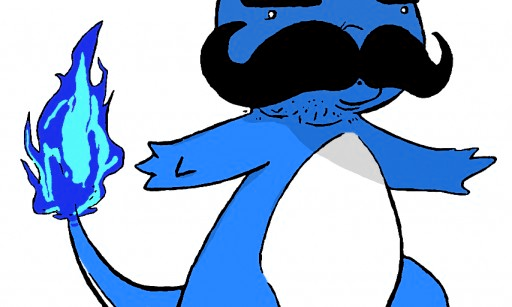

In [ ]:
(test_img)

In [ ]:
test_img.shape


(307, 512, 3)

In [ ]:
test_img=cv2.resize(test_img,(256,256))

In [ ]:
test_input=test_img.reshape((1,256,256,3))

In [ ]:
import numpy as np

# Example array of probabilities
predictions = np.array([model.predict(test_input)])

# List of category names
category_names = ['balbasaur', 'charmander', 'pikachu', 'squirtle']

# Get the index of the maximum probability
predicted_index = np.argmax(predictions)

# Get the corresponding category name
predicted_category = category_names[predicted_index]

print("Predicted category:", predicted_category)


1/1 [==============================] - 0s 25ms/step
Predicted category: charmander
